In [1]:
import DGM
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

In [2]:
# Option parameters
r = 0.03           # Interest rate
sigma = 0.25       # Volatility of first asset
K = 120            # Strike
T = 1           # Terminal time
q = 0
S0 = 100.0          # Initial price of first asset
steps = 100

In [3]:
nSim_interior = 10_000     # Number of interior points
nSim_terminal = 1_000      # Terminal condition points
Epoch = 10_000
S_max = 300

### **PINN Architecture Table**

| **Layer**      | **Number of Neurons** | **Input Variables**           | **Activation Function** | **Output of Layer**                                                          |
| -------------- | --------------------- | ----------------------------- | ----------------------- | ---------------------------------------------------------------------------- |
| Input Layer    | 2                     | $S$, $t$                   | None                    | $\mathbf{x} = [S, t]^\top \in \mathbb{R}^2$                               |
| Hidden Layer 1 | 50                    | $\mathbf{x} \in \mathbb{R}^2$ | $\tanh$                 | $\mathbf{z}^{(1)} = \tanh(W^{(1)} \mathbf{x} + b^{(1)}) \in \mathbb{R}^{50}$ |
| Hidden Layer 2 | 50                    | $\mathbf{z}^{(1)}$            | $\tanh$                 | $\mathbf{z}^{(2)} = \tanh(W^{(2)} \mathbf{z}^{(1)} + b^{(2)})$               |
| Hidden Layer 3 | 50                    | $\mathbf{z}^{(2)}$            | $\tanh$                 | $\mathbf{z}^{(3)} = \tanh(W^{(3)} \mathbf{z}^{(2)} + b^{(3)})$               |
| Output Layer   | 1                     | $\mathbf{z}^{(3)}$            | None                    | $\widehat{V}(S, \tau) = W^{(4)} \mathbf{z}^{(3)} + b^{(4)} \in \mathbb{R}$   |



In [4]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(50, activation='tanh')
        self.hidden2 = tf.keras.layers.Dense(50, activation='tanh')
        self.hidden3 = tf.keras.layers.Dense(50, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, S, tau):
        # Concatenate S and tau along the last axis
        inputs = tf.concat([S, tau], axis=1)  # Shape: (batch_size, 2)
        x = self.hidden1(inputs)
        x = self.hidden2(x)
        x = self.hidden3(x)
        return self.output_layer(x)


### **Sampler Output Summary**

| **Variable Name** | **Shape**   | **Distribution**      | **Values Inside**        | **Purpose**                                                                                        |
| ----------------- | ----------- | --------------------- | ------------------------ | -------------------------------------------------------------------------------------------------- |
| `t_interior`      | (10,000, 1) | $\mathcal{U}(0, 1)$   | Real numbers ∈ \[0, 1]   | Time points for enforcing the Black-Scholes **PDE**                                                |
| `S_interior`      | (10,000, 1) | $\mathcal{U}(0, 300)$ | Stock prices ∈ \[0, 300] | Asset values for enforcing the **PDE**                                                             |
| `t_init`          | (1,000, 1)  | Constant              | All values = 1           | Fixed maturity time to enforce **terminal payoff condition**                                       |
| `S_init`          | (1,000, 1)  | $\mathcal{U}(0, 300)$ | Stock prices ∈ \[0, 300] | Input to model at $t = 1$ to match **option payoff**                                               |
| `t_terminal`      | (1,000, 1)  | $\mathcal{U}(0, 1)$   | Real numbers ∈ \[0, 1]   | Time values to apply **boundary conditions** at $S = 0$ and $S = 300$                              |
| `S_terminal0`     | (1,000, 1)  | Constant              | All values = 0           | Left boundary condition: enforce $V(t, 0) = 0$                                                     |
| `S_terminal1`     | (1,000, 1)  | Constant              | All values = 300         | Right boundary: enforce approximation $V(t, S_{\max}) \approx \max(S_{\max} - K e^{-r(T - t)}, 0)$ |

---



In [5]:
def sampler(nSim_interior, nSim_terminal, S_max):
    ''' Sample time-space points from the function's domain '''
    t_interior = tf.random.uniform(minval = 0, maxval = T, shape=[nSim_interior, 1])
    S_interior = tf.random.uniform(minval = 0, maxval = S_max, shape=[nSim_interior, 1])

    ##initial condition
    t_init = tf.ones((nSim_terminal, 1))
    S_init = tf.random.uniform(minval = 0, maxval = S_max, shape=[nSim_terminal, 1])

    ##Boundary Condition
    t_terminal = tf.random.uniform(minval = 0, maxval = T, shape=[nSim_terminal, 1])
    S_terminal0 = tf.zeros((nSim_terminal, 1))
    S_terminal1 = S_max * tf.ones((nSim_terminal, 1))
    
    return t_interior, S_interior, t_init, S_init, t_terminal, S_terminal0, S_terminal1

### **1. PDE Residual Loss (L1)**

In the Black-Scholes PDE:

$$
\frac{\partial V}{\partial t} + r S \frac{\partial V}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} - r V = 0
$$

You sample interior points $(t, S) \in (0, T) \times (0, S_{\max})$, and enforce this PDE approximately through:

$$
\text{diff}_V(t, S) = \frac{\partial V}{\partial t}(t, S) + r S \frac{\partial V}{\partial S}(t, S) + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}(t, S) - r V(t, S)
$$

Then penalize deviations by computing:

$$
\mathcal{L}_1 = \mathbb{E}_{(t,S) \sim \text{Interior}} \left[ \left( \text{diff}_V(t, S) \right)^2 \right]
$$

---

### **2. Terminal Condition Loss (L2)**

At maturity $t = T$, the solution must match the terminal payoff for a **European call option**:

$$
V(T, S) = \max(S - K, 0)
$$

So, this loss enforces that:

$$
\mathcal{L}_2 = \mathbb{E}_{S \sim \text{Init}} \left[ \left( V(T, S) - \max(S - K, 0) \right)^2 \right]
$$

---

### **3. Boundary Condition at $S = 0$ (L3)**

For a call option, if the underlying price is zero, the option is worthless:

$$
V(t, 0) = 0 \quad \forall t \in [0, T]
$$

So the loss:

$$
\mathcal{L}_3 = \mathbb{E}_{t \sim \text{Boundary}} \left[ \left( V(t, 0) \right)^2 \right]
$$

---

### **4. Boundary Condition at $S = S_{\max}$ (L4)**

At the other spatial boundary, $S = S_{\max}$, the option behaves approximately like its intrinsic value (discounted):

$$
V(t, S_{\max}) \approx \max(S_{\max} - K e^{-r(T - t)}, 0)
$$

So the boundary loss is:

$$
\mathcal{L}_4 = \mathbb{E}_{t \sim \text{Boundary}} \left[ \left( V(t, S_{\max}) - \max(S_{\max} - K e^{-r(T - t)}, 0) \right)^2 \right]
$$

---

### **Final Loss**

All components are combined to form the **total loss**:

$$
\boxed{
\mathcal{L} = \mathcal{L}_1 + \mathcal{L}_2 + \mathcal{L}_3 + \mathcal{L}_4
}
$$

This encourages the model to satisfy:

* the PDE in the domain,
* the terminal payoff condition,
* the boundary condition at $S = 0$,
* and the boundary behavior as $S \to \infty \approx S_{\max}$.



In [6]:
@tf.function
def loss(model, T, t_interior, S_interior, t_init, S_init, t_terminal, S_terminal0, S_terminal1):
    ''' Compute total loss for training. '''
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t_interior)
        tape.watch(S_interior)
        
        V = model(t_interior, S_interior)
        
        V_t = tape.gradient(V, t_interior)
        V_s = tape.gradient(V, S_interior)
        V_ss = tape.gradient(V_s, S_interior)

    # 2D Black-Scholes PDE residual
    diff_V = V_t + r * S_interior * V_s + 0.5 * sigma**2 * S_interior**2 * V_ss - r * V

    L1 = tf.reduce_mean(tf.square(diff_V))

    # inital condition t = T
    C_init = model(t_init, S_init)
    #payoff = tf.nn.relu(S_init - K * tf.exp(-r * T))
    payoff = tf.nn.relu(S_init - K)
    L2 = tf.reduce_mean(tf.square(C_init - payoff))
    
    # Terminal condition 1 S = 0
    C_term0 = model(t_terminal, S_terminal0)
    L3 = tf.reduce_mean(tf.square(C_term0))

    # Terminal condition 2 S = S_max
    C_term1 = model(t_terminal, S_terminal1)
    tau = T - t_terminal
    payoff_max = tf.nn.relu(S_terminal1 - K * tf.exp(-r * tau))
    L4 = tf.reduce_mean(tf.square(C_term1 - payoff_max))
    
    return L1 + L2 + L3 + L4

In [7]:
model = PINN()
optimizer = tf.optimizers.Adam(learning_rate=0.001)

### **Neural Network Output**

###  $\widehat{V}_\theta(S, t)$

* This is the **output of the neural network**.
* It represents the **predicted option price** at input $S$ (stock price) and $t$ (time).
* The subscript $\theta$ denotes the **dependence on the network parameters**, which include:

  * Weights and biases from all layers:

    $$
    \theta = \left\{ W^{(l)}, b^{(l)} \right\}_{l=1}^4
    $$
* So, you can write:

  $$
  \widehat{V}_\theta(S, t) = \text{NN}_\theta(S, t)
  $$

This is what you're training the model to approximate:

$$
\widehat{V}_\theta(S, t) \approx V_{\text{true}}(S, t)
$$

---

##  **Loss Function**

###  $\mathcal{L}(\theta)$

* This is the **total loss function** used to train the model.
* It's composed of four parts, each enforcing one component of the Black-Scholes problem:

  $$
  \mathcal{L}(\theta) = \underbrace{\mathcal{L}_\text{PDE}}_{L_1} + \underbrace{\mathcal{L}_\text{payoff}}_{L_2} + \underbrace{\mathcal{L}_{S=0}}_{L_3} + \underbrace{\mathcal{L}_{S=S_{\max}}}_{L_4}
  $$

Each part measures mean squared error (MSE) over sampled points. Example:

$$
\mathcal{L}_\text{PDE} = \mathbb{E}_{(t, S)}\left[\left( \frac{\partial \widehat{V}_\theta}{\partial t} + r S \frac{\partial \widehat{V}_\theta}{\partial S} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 \widehat{V}_\theta}{\partial S^2} - r \widehat{V}_\theta \right)^2 \right]
$$

---

##  **Gradient**

###  $\nabla_\theta \mathcal{L}(\theta)$

* This is the **gradient of the loss function** with respect to all trainable parameters in the model:

  $$
  \nabla_\theta \mathcal{L}(\theta) = \left[ \frac{\partial \mathcal{L}}{\partial \theta_1}, \frac{\partial \mathcal{L}}{\partial \theta_2}, \ldots \right]
  $$
* TensorFlow computes this using **automatic differentiation** via `tf.GradientTape()`.

---

##  **Gradient Descent Update Rule**

After computing the gradient $\nabla_\theta \mathcal{L}(\theta)$, the parameters are updated using:

$$
\theta \leftarrow \theta - \eta \nabla_\theta \mathcal{L}(\theta)
$$

Where:

* $\eta$ is the **learning rate**
* This update is applied using `optimizer.apply_gradients(...)`



In [8]:
@tf.function
def train_step(T, t_interior, S_interior, t_init, S_init, t_terminal, S_terminal0, S_terminal1):
    with tf.GradientTape() as tape:
        total_loss = loss(model, T, t_interior, S_interior, t_init, S_init, t_terminal, S_terminal0, S_terminal1)
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return total_loss
    

In [9]:
from tqdm import tqdm
for i in tqdm(range(Epoch)):
    t_interior, S_interior, t_init, S_init, t_terminal, S_terminal0, S_terminal1 = sampler(nSim_interior, nSim_terminal, S_max)    
    
    total_loss = train_step(T, t_interior, S_interior, t_init, S_init, 
                            t_terminal, S_terminal0, S_terminal1)
    if i % 1000 == 0:
        print(f"Total loss: {total_loss:.5f}")


        

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

2025-07-01 11:19:16.097583: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
  0%|                                         | 9/10000 [00:00<09:03, 18.37it/s]

Total loss: 39087.80078


 10%|███▊                                  | 1011/10000 [00:21<02:41, 55.69it/s]

Total loss: 17693.28906


 20%|███████▋                              | 2010/10000 [00:41<02:30, 52.95it/s]

Total loss: 7891.87500


 30%|███████████▍                          | 3010/10000 [01:01<02:24, 48.33it/s]

Total loss: 2984.72046


 40%|███████████████▏                      | 4009/10000 [01:21<01:57, 50.88it/s]

Total loss: 952.82153


 50%|███████████████████                   | 5009/10000 [01:41<01:39, 49.99it/s]

Total loss: 269.35873


 60%|██████████████████████▊               | 6008/10000 [02:00<01:25, 46.90it/s]

Total loss: 96.13418


 70%|██████████████████████████▋           | 7009/10000 [02:21<00:59, 50.39it/s]

Total loss: 143.47203


 80%|██████████████████████████████▍       | 8007/10000 [02:40<00:41, 47.65it/s]

Total loss: 0.68129


 90%|██████████████████████████████████▏   | 9006/10000 [03:00<00:17, 55.64it/s]

Total loss: 0.41362


100%|█████████████████████████████████████| 10000/10000 [03:20<00:00, 49.99it/s]


### This computes the **Black-Scholes price** $C(S, t)$ for a **European call option** with:

* $S$: current asset price
* $K$: strike price
* $r$: risk-free interest rate
* $\sigma$: volatility
* $t$: current time
* $T$: maturity (taken as global)

---

## **Mathematical Formula (When $\tau = T - t > 0$)**

1. **Time to maturity**:

   $$
   \tau = T - t
   $$

2. **Black-Scholes parameters**:

   $$
   d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2} \sigma^2 \right)\tau}{\sigma \sqrt{\tau}}
   \quad,\quad
   d_2 = d_1 - \sigma \sqrt{\tau}
   $$

3. **Call option price**:

   $$
   C(S, t) = S \cdot N(d_1) - K e^{-r \tau} \cdot N(d_2)
   $$

   Where:

   * $N(\cdot)$: Cumulative distribution function (CDF) of the standard normal distribution
   * $e^{-r\tau}$: Discount factor for the strike price

Mathematically:

$$
C(S, T) = \max(S - K, 0)
$$

This is the **payoff** of a European call option at maturity.




In [ ]:
def black_scholes_calls(S, K, r, sigma, t):
    tau = T - t
    if tau == 0:
        return np.maximum(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

### **Evaluation Variable Breakdown**

| **Variable Name** | **Shape** | **Type / Source**        | **Values Inside**                                             | **Purpose / Description**                                                 |
| ----------------- | --------- | ------------------------ | ------------------------------------------------------------- | ------------------------------------------------------------------------- |
| `S_eval`          | (100, 1)  | `tf.Tensor (float32)`    | 100 values linearly spaced in $[0, S_{\max}]$                 | Asset prices for evaluating the option at time $t = 0$ (i.e., $\tau = T$) |
| `tau_eval`        | (100, 1)  | `np.ndarray → tf.Tensor` | All entries = 0                                               | Time-to-maturity = T (i.e., evaluation is at the start)                    |
| `C_nn`            | (100, 1)  | `np.ndarray`             | Predicted option prices from the **PINN** model               | Model output: $\widehat{V}_\theta(S, t=0)$                             |
| `C_bs`            | (100,)    | `list of floats`         | Black-Scholes formula output for each $S \in S_{\text{eval}}$ | Analytical solution: $C_{\text{BS}}(S, t=0) = \max(S - K, 0)$          |

---

### ✅ **Evaluation Context**

* You're comparing:

  * **`C_nn`**: the PINN’s predicted price at $t = 0$ (time to maturity = T),
  * **`C_bs`**: the exact price using the Black-Scholes formula.


---


/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_62102/2890217726.py:5: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


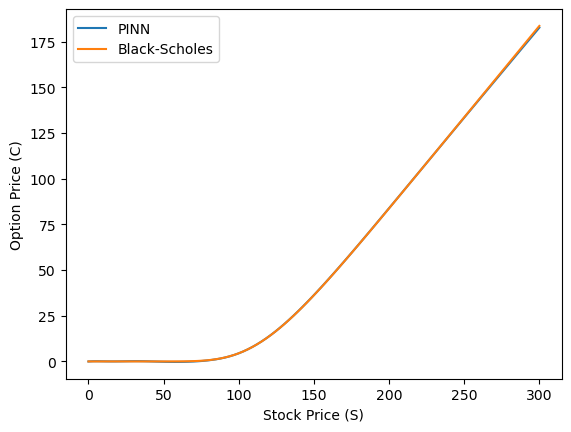

In [13]:
# Evaluation
S_eval = np.linspace(0, S_max, 100).reshape(-1,1)
S_eval = tf.convert_to_tensor(S_eval, dtype=tf.float32)
tau_eval = 0 * np.ones_like(S_eval)

C_nn = model(tau_eval, S_eval).numpy()
C_bs = [black_scholes_calls(S.numpy()[0], K, r, sigma, 0) for S in S_eval]

# Plot results
plt.plot(S_eval.numpy(), C_nn, label='PINN')
plt.plot(S_eval.numpy(), C_bs, label='Black-Scholes')
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Price (C)')
plt.legend()
plt.show()